# 8 Queens

### Introduction

<figure>
<img src="resources/eight_queens_moves.png", width=300 align="right">
    <figcaption></figcaption>
</figure>

The [Eight Queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) is a famous puzzle that has been studied extensively in- and outside of computer science. It was first published in the chess magazine _Schach_ in 1848. 

The problem can be formulated as follows: 

_"Place 8 queens on a regular (8x8) chess board such that no queen attacks any other queen."_

A queen in the game of chess can move horizontally, vertically, and diagonally. The puzzle can be solved by hand (and even [Carl Friedrich Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss) studied it back in 1850).

The EightQueensState class below, as well as the methods defined, should prove a helpful start for a Genetic Algorithms approach. However, you are welcome to change as little or as much of the code as is useful.

In [1]:
import numpy as np

class EightQueensState:
    """This class represents a board in the eight queens puzzle"""
    def __init__(self, state=None, n=8):
        """
        :param state: pass in a numpy array of integers to set the state, otherwise will be generated randomly
        :param n: only used if state is not provided, determines size of board (default: 8)
        """
        if state is None:
            self.n = n
            state = np.random.randint(0, n, n)
        else:
            self.n = len(state)
        self.state = state

    @staticmethod
    def copy_replace(state, i, x):
        """This creates a copy of the state (important as numpy arrays are mutable) with column i set to x"""
        new_state = state.copy()
        new_state[i] = x
        return new_state

    @staticmethod
    def range_missing(start, stop, missing):
        """
        This creates a list of numbers with a single value missing
        e.g. range_missing(0, 8, 2) -> [0, 1, 3, 4, 5, 6, 7]
        """
        return list(range(start, missing)) + list(range(missing + 1, stop))

    def cost(self):
        """Calculates the number of pairs attacking"""
        count = 0
        for i in range(len(self.state) - 1):
            # for each queen, look in columns to the right
            # add one to the count if there is another queen in the same row
            count += (self.state[i] == np.array(self.state[i + 1:])).sum()

            # add one to the count for each queen on the upper or lower diagonal
            upper_diagonal = self.state[i] + np.arange(1, self.n - i)
            lower_diagonal = self.state[i] - np.arange(1, self.n - i)
            count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
            count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
        return count
    
    def neighbourhood(self):
        """This generates every state possible by changing a single queen position"""
        neighbourhood = []
        for column in range(self.n):
            for new_position in self.range_missing(0, self.n, self.state[column]):
                new_state = self.copy_replace(self.state, column, new_position)
                neighbourhood.append(EightQueensState(new_state))

        return neighbourhood

    def random_neighbour(self):
        """Generates a single random neighbour state, useful for some algorithms"""
        column = np.random.choice(range(self.n))
        new_position = np.random.choice(self.range_missing(0, self.n, self.state[column]))
        new_state = self.copy_replace(self.state, column, new_position)
        return EightQueensState(new_state)

    def is_goal(self):
        return self.cost() == 0

    def replace_str_index(self, text,index=0,replacement=''):
        return '%s%s%s'%(text[:index],replacement,text[index+1:])
    
    def __str__(self):
        print(' ', *np.arange(0, self.n,1))
        temp = '. ' * self.n
        for i in range(self.n-1,-1,-1):
            if i in self.state:
                matches = np.where(self.state==i)
                row = temp
                for match in matches[0]:
                    row = self.replace_str_index(row,index= match*2, replacement='X')
                print( i, row)
            else: 
                print( i, temp)
        if self.is_goal():
            return f"Goal state! {self.state}"
        else:
            return f"\n{self.state} fitness {-self.cost()}\n"
                 
    def __eq__(self, other):
        if (other.state == self.state).all():
            return True
        else:
            return False
        

# Task 1: 
 I use suggested `EightQueensState()` class then update its __str__ method futher to allow printing the board of the game for better visualization. 
 
For implementing genetic algorithm, I created `Genetic_Algorithm_8` which I implement using the pseudocode from Russell and Norvig. I created more class methods than illustrated in the pseudocode, I added: *mutate*, *random_intial_population*, *fitness_function* in a seperate method to the main *search* method in order to allow for better code readability. my implementation choice for this was: 
- Poulation size = 80
- Initialisation: random
- Parent selection: Fitness Proportional Selection (FPS)
- Mutation rate = 0.04
- Crossover : One-point crossover
- Crossover rate = 0.5
- Number of offspring = 80
- Survival selection: fitness-based method
- Termination condition: 30 sec based with no optimal solution reached. 




   0 1 2 3 4 5 6 7
7 . . . . . X . . 
6 X . . . . . . . 
5 . . . . X . . . 
4 . X . . . . . . 
3 . . . . . . . X 
2 . . X . . . . . 
1 . . . . . . X . 
0 . . . X . . . . 
Goal state! [6 4 2 0 5 7 1 3]
Time elapsed: 4.98 sec
Number of childer reproduced are:  2956
Number of new populations created:  36


Text(0.5, 1.0, '\nMean Population Fitness Evolution')

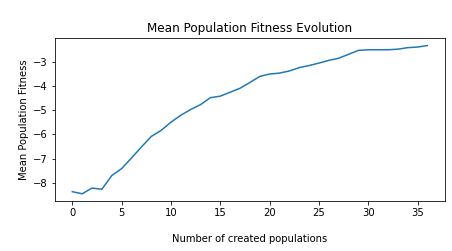

In [2]:
from random import choices
import math
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from collections import Counter

class Genetic_Algorithm_8:
    """Applies genetic algorithm to solve the 8 queens puzzle"""
    def __init__(self, state = EightQueensState,
                 poulation_size = 8*10,
                 mutation_rate = 0.04,
                 crossover_rate = 0.5, verbose= True):
        self.state = state
        self.k = poulation_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.verbose = verbose
        
    
    @staticmethod
    def reproduce(state1, state2, crossover_rate):
        """get a new state from the reproduction of two randomly selected states by choosing a random One-Point Crossover
        I use range [1, N-1] to choose a crossover point in order to prevent it from falling before the first position
        or after the last position"""
        crossover_point = choices([x for x in range(1, state1.n-1)])[0]
        new_state_1, new_state_2 = state1.state.copy(), state2.state.copy()
        
        if random.random() < crossover_rate : 
            new_state_1[:crossover_point] = state2.state[:crossover_point]
            new_state_2[:crossover_point] = state1.state[:crossover_point]
            return EightQueensState(new_state_1), EightQueensState(new_state_2)
        else:
            return state1, state2
        

    @staticmethod
    def mutate(state, mutation_rate):
        """select a random value for a random columns and get a new mutated state
        I use random.random() that generates numbers uniformally in [0, 1), 0 inclusive and 1 exclusive"""
        if random.random() < mutation_rate : 
            return EightQueensState(state.copy_replace(state.state, choices([x for x in range(state.n)])[0], choices([x for x in range(state.n)])[0]))
        else: 
            return state
                
    @staticmethod
    def random_intial_population(state1):
        """select a random value for a random columns and get a new mutated state"""
        intial_population = [state1.state.random_neighbour() for n in range(state1.k)]
        
        #remove redundant states in order to prevent skewness in the random selection below
        redundant = []
        for index, cand_state in enumerate(intial_population):
            for another_cand in intial_population[index+1:]:
                if cand_state == another_cand:
                    redundant.append(another_cand)
        if redundant is not None: 
            remove_count = 0
            for removable in redundant:
                try:
                    intial_population.remove(removable)
                    remove_count += 1
                except:
                    pass
        return intial_population
    
    @staticmethod
    def fitness_function(population):
        # the fitness (to be maximised) of an individual is -[cost] of the state 
        fitness_population  = [-individual.cost() for individual in population]
        mean_population_fitness = sum(fitness_population)/len(fitness_population)
        #weighted fitness 
        return [x/sum(fitness_population) for x in fitness_population], mean_population_fitness

    def search(self):
        """
        main search action using genetic algorithm.  
        """
        t_start = time.perf_counter()
        if self.state.is_goal():
            return True, self.state, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log

        # select initial population
        population  = Genetic_Algorithm_8.random_intial_population(self)
        
        if self.verbose:
            print(self.state.n, 'Queen Puzzle')
            print('Initial state:\n', self.state)
            print('Random initial population:')
            i= 1
            for state in population:
                print(i, '-\n', state)
                i += 1

        mutation_cycles = 0
        n_population_created = 0
        count_identicals_generation = 0
        mean_population_fitness_log = []
        
        '''Termination Condition: maximally allowed time elapses.
        since genetic algorithm has completeness issue, iterations are time constrained. 
        algorthim will work to find solution in maximum 31 sec, else, no solution found message is returned''' 
        while time.perf_counter() - t_start < 31:     
            children =[]
            fit_indicator, mean_population_fitness = Genetic_Algorithm_8.fitness_function(population)
            mean_population_fitness_log.append(mean_population_fitness)
            for n in range(math.ceil(self.k/2)):
                # Fitness Proportional Selection (FPS): random parent selection based on weighted probability 
                # of fitness function of each individual inside the population
                try:
                    x, y = np.random.choice(population, size= 2, replace= False, p= fit_indicator)
                except:
                    pass

                reproduced_x, reproduced_y = Genetic_Algorithm_8.reproduce(x,y, self.crossover_rate)            
                mutated_x, mutated_y = Genetic_Algorithm_8.mutate(reproduced_x, self.mutation_rate), Genetic_Algorithm_8.mutate(reproduced_y, self.mutation_rate)
                if mutated_x.is_goal():
                    return True, mutated_x, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log
                if mutated_y.is_goal():
                    return True, mutated_y, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log
                children.append(mutated_x)
                children.append(mutated_y)
                mutation_cycles += 2
                 
                if self.verbose:
                    print('The two states which selected for mating in this round are:\n', x,'\n', y)
                    print('Resulting states after reproducing:\n', reproduced_x, '\n', reproduced_y)
                    print('Resulting states after mutation:\n', mutated_x, '\n', mutated_y)
                    print('........'*4)
                
                
            # add only unique states
            merged = population.copy()
            for child in children:
                if child not in population:
                    merged.append(child)
    
            # fitness-based method allows the best organism(s) from the current population  
            # to carry over to the next, unaltered, hence algorithm converges. 
            new_population = sorted(merged, key=lambda x: x.cost(), reverse=False)[:self.k]
            

            population = new_population
            n_population_created += 1
            if self.verbose:
                print('New population:')
                for new_state in population: 
                    print(new_state)
                print('/////////'*10, '\n')
        return False, population[0], mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log

state = EightQueensState(n= 8)
GenA = Genetic_Algorithm_8(state, poulation_size = 80,
                           mutation_rate= 0.05, crossover_rate = 0.5, verbose= False)

solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
if solved:
    print('\n\n', solution)
else :
    print('31 sec elapsed. Goal state was not reached.')
    print('Best fit individual is:\n', solution)
    
print('Time elapsed:', round(time_elapsed, 2), 'sec')
print('Number of childer reproduced are: ', mutation_cycles)
print('Number of new populations created: ', n_population_created )
# plot the evolution of the mean population fitness to ensure that MPF is increasing with new generations. 
plt.figure(figsize=(7, 3))
sns.lineplot(data = mean_population_fitness_log)
plt.xlabel('\nNumber of created populations')
plt.ylabel('\nMean Population Fitness')
plt.title('\nMean Population Fitness Evolution')

Mean population fitness is increasing sharply in the first section of the graph then increase rate drops and goal state is reached. 

`Genetic_Algorithm_8` offers a peek behind the curtain with its attribute **verbose**. 

Print statements are added to show the individuals' genome and their evolution through: initialization, forming population, parents selection, reproduction, mutation and survivor selection. It is noticeable the drop in number of generation created when keeping population size at 80 individual. This is because *print* statements (for such data volume) takes computing power off generations creation, therefore, when verbose is activated, `Genetic_Algorithm_8` can rarely find the optimal solution in the 30 sec time constraint, eventhough, I lower the population size. 

8 Queen Puzzle
Initial state:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 6 2 4 3 5 3] fitness -10

Random initial population:
1 -
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

2 -
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

3 -
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

4 -
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . 

0 . . . . . . . . 

[5 7 6 2 2 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X X . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 6 2 2 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X X . . . 
1 . . . . . . . . 
0

   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .

  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . .

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .

   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 7 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 6 2 4 3 5 3] fitness -10

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . 

   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . .

2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 


  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X 


////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9



 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . 


Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . 

4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 

   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . .

 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . 

5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6

 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X 


[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . 

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . .

2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 

1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1

 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . .

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round

0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . .

 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 

2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5


  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
 

   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .


  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
 

6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 

 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X .


  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 

 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .


................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this roun

2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5


  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
 

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .

6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 

 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 6 2 4 3 5 3] fitness -10

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . .

3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . .

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X 


Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . 

6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . .


Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . 


Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X 

   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .

  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . .

   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .

 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 


  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

Resulting states after reproducing:
   

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X 

   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . .


  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 

4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . X . . . . . . 

[5 0 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 

0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0


[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X .


Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X

................................
New population:
  0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

  0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9

  0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

////////////////////////////////////////////////////////////////////////////////////////// 

The two states which selected for mating in this round

0 . . . . . . . . 

[5 7 6 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . X . . . . . . 

[5 0 7 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 6 2 4 3 5 3] fitness -10

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . . . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . X . . . 
0 . X . . . . . . 

[5 0 7 2 1 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X . . . . . . 
6 . . X . . . . . 
5 X . . . . 

1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitn

4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8

................................
The two states which selected for mating in this round are:
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 7 2 4 3 5 3] fitness -8
 
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . 

4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after reproducing:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness -9

Resulting states after mutation:
   0 1 2 3 4 5 6 7
7 . X X . . . . . 
6 . . . . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . . . . . . . . 

[5 7 7 2 4 3 5 3] fitness -9
 
   0 1 2 3 4 5 6 7
7 . . . . . . . . 
6 . . X . . . . . 
5 X . . . . . X . 
4 . . . . X . . . 
3 . . . . . X . X 
2 . . . X . . . . 
1 . . . . . . . . 
0 . X . . . . . . 

[5 0 6 2 4 3 5 3] fitness

Text(0.5, 1.0, '\nMean Population Fitness Evolution')

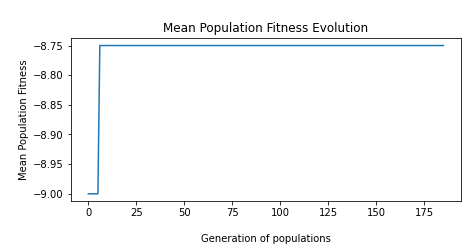

In [3]:
state = EightQueensState(n= 8)
GenA = Genetic_Algorithm_8(state, poulation_size = 4,
                           mutation_rate= 0.01, crossover_rate = 0.5, verbose= True)

solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
if solved:
    print('\n\n', solution)
else :
    print('31 sec elapsed. Goal state was not reached.')
    print('Best fit individual is:\n', solution)
    
print('Time elapsed:', round(time_elapsed, 2), 'sec')
print('Number of reproducing mates are: ', mutation_cycles)
print('Number of new populations created: ', n_population_created )
# plot the evolution of the mean population fitness to ensure that MPF is increasing with new generations. 
plt.figure(figsize=(7, 3))
sns.lineplot(data = mean_population_fitness_log)
plt.xlabel('\nGeneration of populations')
plt.ylabel('\nMean Population Fitness')
plt.title('\nMean Population Fitness Evolution')

Although time limit has reached and goal state has not been reached, the object returned the best fit individual available in the population pool. 


Results are amazing so far. However, because of the stochastic nature of EAs, a good estimation of `Genetic_Algorithm_8` performance requires multiple runs on the same problem. Therefore, I run 8 queen puzzle for 100 times and plot the answer to figure out the capability of `Genetic_Algorithm_8`.

83 solutions were found for 8 queen puzzle. 52 of them are unique


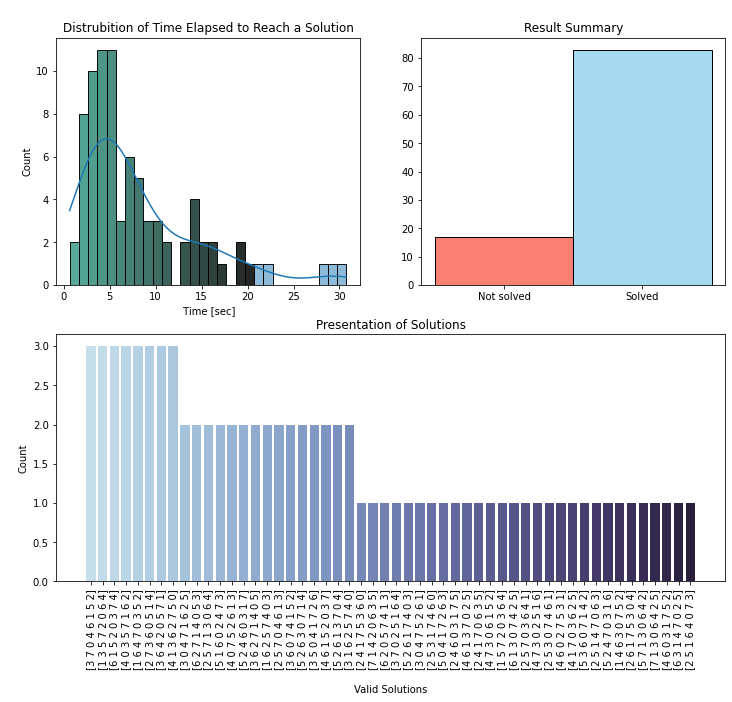

In [4]:
count_solved = []
time_elapsed_log = []
reached_solution = []
MBF_log = [] 
AES_log = []

for i in range(0,100):
    state = EightQueensState(n= 8)
    GenA = Genetic_Algorithm_8(state, poulation_size = 80,
                               mutation_rate= 0.05, crossover_rate = 0.5, verbose= False)
    solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
    MBF_log.append(-solution.cost())
    if solved:
        time_elapsed_log.append(time_elapsed)
        count_solved.append('Solved')
        reached_solution.append(solution.state)
        AES_log.append(mutation_cycles)
    else: 
        count_solved.append('Not solved')  
        
         

gs = gridspec.GridSpec(2, 2)


fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
cm = sns.color_palette("dark:#5A9_r", 20)
sns.histplot(data = time_elapsed_log, bins= 30, kde=True, ax=ax1)
ax1.set(xlabel=' Time [sec]')
for bin_,i in zip(ax1.patches,cm):
    bin_.set_facecolor(i)
plt.title('\nDistrubition of Time Elapsed to Reach a Solution')


ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
sns.histplot(data= count_solved, color='skyblue', ax=ax2)
ax2.patches[0].set_facecolor('salmon')
ax2.set(ylabel=None)
plt.title('\nResult Summary')


ax3 = fig.add_subplot(gs[1, :]) 
# count number of unique solution and put it in a dictionary 
count_solutions_dic = Counter(str(e) for e in reached_solution)
print(f'{sum(count_solutions_dic.values())} solutions were found for 8 queen puzzle. {len(count_solutions_dic)} of them are unique')

#plot the dictionary
ind = np.arange(len(count_solutions_dic))
palette = sns.color_palette("ch:s=.25,rot=-.25", len(count_solutions_dic))
ax3.bar(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).values(), color=palette)
plt.xticks(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).keys(), rotation = 90)
plt.xlabel('\nValid Solutions')
plt.ylabel('\nCount')
plt.title('\nPresentation of Solutions')

plt.show()

In 100 run of the 8 queen puzzle, `Genetic_Algorithm_8` resolves the puzzle in 83 round out of 100. It came up with 83 solutions, 52 of them are unique.  The distribution for time elapsed to reach a solution is right-skewed. I note that the majority of solutions took less than 10 sec with around 7 sec median time. 

# Task 2: 

I implement the 5 improvements to basic GA: 
- Allow the algorithm to handle N queen problems by relaxing the termination condition of time constraint (from 31 to 61 sec) also introducing new condition that monitor if fitness improvement remains under a threshold value for 10 sec.  

- Tournament selection algorithm: this is a method for parent selection that select randomly a k individual from population then pick the fittest pair for mutation. FPS suffers a problem of premature convergence. Outstanding individuals take over the entire population very quickly. This tends to focus the search process, and makes it less likely that the algorithm will thoroughly search the space of possible solutions, where better solutions may exist.

- When fitness values are all very close together, there is almost no selection pressure. Therefore, later in a run, when some convergence has taken place and the worst individuals are gone, it is observed that the mean population fitness only increases very slowly. I introduce a condition that bypass fitness-based method for survivor selection when new population is identical to existing population for 4 consecutive rounds. This would choose randomly from the merged pool of existing population and children.

- Swap mutation allow to maintain permutations intact. Two positions (genes) in the chromosome are selected at random and their allele values swapped. 

- Enhance diversity by removing redundant children. The diversity of a population is a measure of the number of different solutions present. I remove offspring whose genotypes are identical to individual in population. Figure 3 illustrates a valid solution for 12 queen puzzle, the solution was reached in 32 sec and 181 round of generations. 



   0 1 2 3 4 5 6 7 8 9 10 11
11 . . . . X . . . . . . . 
10 . . . . . . X . . . . . 
9 . . . . . . . . X . . . 
8 . . X . . . . . . . . . 
7 . . . . . . . . . . . X 
6 . . . X . . . . . . . . 
5 X . . . . . . . . . . . 
4 . . . . . . . . . X . . 
3 . . . . . X . . . . . . 
2 . . . . . . . . . . X . 
1 . X . . . . . . . . . . 
0 . . . . . . . X . . . . 
Goal state! [ 5  1  8  6 11  3 10  0  9  4  2  7]
Time elapsed: 30.64 sec
Number of reproducing mates are:  21790
Number of new populations created:  181


Text(0.5, 1.0, '\nMean Population Fitness Evolution')

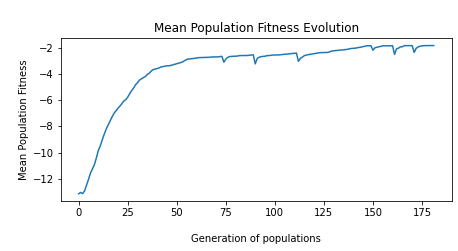

In [55]:
class Genetic_Algorithm:
    """Applies genetic algorithm to solve the N queens puzzle"""
    def __init__(self, state = EightQueensState(),
                 poulation_size = 40,
                 #if FPS is True then K tournament selection is not relevant, 
                 #if false then tournament selection is used for parent selection
                 FPS= True, tournament_selection_k = 4, 
                 swap = False, mutation_rate = 0.04,
                 crossover_rate = 0.5, verbose= True):
        
        self.state = state
        self.k = poulation_size
        self.FPS = FPS
        self.tournament_selection_k = tournament_selection_k
        self.swap = swap
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.verbose = verbose
        
    
    @staticmethod
    def reproduce(state1, state2, crossover_rate):
        """get a new state from the reproduction of two randomly selected states by choosing a random One-Point Crossover
        I use range [1, N-1] to choose a crossover point in order to prevent it from falling before the first position
        or after the last position"""
        crossover_point = choices([x for x in range(1, state1.n-1)])[0]
        new_state_1, new_state_2 = state1.state.copy(), state2.state.copy()
        
        if random.random() < crossover_rate : 
            new_state_1[:crossover_point] = state2.state[:crossover_point]
            new_state_2[:crossover_point] = state1.state[:crossover_point]
            return EightQueensState(new_state_1), EightQueensState(new_state_2)
        else:
            return state1, state2
        

    @staticmethod
    def mutate(state, swap, mutation_rate):
        """swap mutation: select two random values of two columns, swap their values and get a new mutated state
        or select a random value for a random columns and get a new mutated state, 
        I use random.random() that generates numbers uniformally in [0, 1), 0 inclusive and 1 exclusive"""
        
        if random.random() < mutation_rate :
            if swap: 
                x1 = choices([x for x in range(state.n)])[0]
                x2 = choices([x for x in range(state.n)])[0]
                while x1 == x2:
                    x2 = choices([x for x in range(state.n)])[0]
                x2_value = state.state[x1]
                x1_value = state.state[x2]
                current_state_list = state.state
                current_state_list[x1] = x1_value
                current_state_list[x2] = x2_value
                return EightQueensState(current_state_list)
            else:
                return EightQueensState(state.copy_replace(state.state, choices([x for x in range(state.n)])[0], choices([x for x in range(state.n)])[0]))
        
        else: 
            return state
            
    
    @staticmethod
    def random_intial_population(state1):
        """select a random value for a random columns and get a new mutated state"""
        intial_population = [state1.state.random_neighbour() for n in range(state1.k)]
        
        #remove redundant states in order to prevent skewness in the random selection below
        redundant = []
        for index, cand_state in enumerate(intial_population):
            for another_cand in intial_population[index+1:]:
                if cand_state == another_cand:
                    redundant.append(another_cand)
        if redundant is not None: 
            remove_count = 0
            for removable in redundant:
                try:
                    intial_population.remove(removable)
                    remove_count += 1
                except:
                    pass

        return intial_population
    
    @staticmethod
    def fitness_function(population):
        # the fitness (to be maximised) of an individual is -[cost] of the state 
        fitness_population  = [-individual.cost() for individual in population]
        mean_population_fitness = sum(fitness_population)/len(fitness_population)
        #weighted fitness 
        return [x/sum(fitness_population) for x in fitness_population], mean_population_fitness
    
    
    def search(self):
        """
        main search action using genetic algorithm.  
        """
        t_start = time.perf_counter()
        if self.state.is_goal():
            return True, self.state, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log

        # select initial population
        population  = Genetic_Algorithm.random_intial_population(self)
        
        if self.verbose:
            print(self.state.n, 'Queen Puzzle')
            print('Initial state: ', self.state)
            print('Random initial population:')
            i= 1
            for state in population:
                print(i, '-\n', state)
                i += 1

        mutation_cycles = 0
        n_population_created = 0
        count_identicals_generation = 0
        number_of_fitness_evaluations = 0
        max_mean_population_fitness = -2000
        mean_population_fitness_log = []
        
        '''Termination Condition: maximally allowed time elapses.''' 
        while time.perf_counter() - t_start < 61:   
            children =[]
            fit_indicator, mean_population_fitness = Genetic_Algorithm.fitness_function(population)
            mean_population_fitness_log.append(mean_population_fitness)
            
            '''Termination Condition: fitness improvement remains under a threshold value for a given period of time (10 sec)'''
            if mean_population_fitness > max_mean_population_fitness:
                max_mean_population_fitness = mean_population_fitness
                first_time_reaching_max_MPF = time.perf_counter()
            elif  time.perf_counter() - first_time_reaching_max_MPF > 10: 
                return False, population[0], mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log

            for n in range(math.ceil(self.k/2)):
                if self.FPS:
                    # Fitness Proportional Selection (FPS): random parent selection based on weighted probability 
                    # of fitness function of each individual inside the population
                    try:
                        x, y = np.random.choice(population, size= 2, replace= False, p= fit_indicator)
                    except:
                        pass
                else:    
                    # tournament selection
                    mating_pool =[0,0]
                    for i in [0,1]:
                        k_individual = np.random.choice(population, size= self.tournament_selection_k , replace= False)
                        mating_pool[i] = sorted(list(k_individual), key=lambda x: x.cost(), reverse=False)[:1]
                    x1, y1 = mating_pool
                    x = x1[0]
                    y = y1[0]

                reproduced_x, reproduced_y = Genetic_Algorithm.reproduce(x,y, self.crossover_rate)
                
                mutated_x, mutated_y = Genetic_Algorithm.mutate(reproduced_x, self.swap, self.mutation_rate),Genetic_Algorithm.mutate(reproduced_y,self.swap, self.mutation_rate)
                if mutated_x.is_goal():
                    return True, mutated_x, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log
                if mutated_y.is_goal():
                    return True, mutated_y, mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log
                children.append(mutated_x)
                children.append(mutated_y)
                mutation_cycles += 2
                 
                if self.verbose:
                    print('The two states which selected for mating in this round are:\n', x,'\n', y)
                    print('Resulting states after reproducing:\n', reproduced_x, '\n', reproduced_y)
                    print('Resulting states after mutation:\n', mutated_x, '\n', mutated_y)
                    print('........'*4)
                
                
            # add only unique states
            merged = population.copy()
            for child in children:
                if child not in population:
                    merged.append(child)        
            
            # Elitism selection (fitness-based method) this allow the best organism(s) from the current population  
            # to carry over to the next, unaltered, hence algorithm converges. 
            new_population = sorted(merged, key=lambda x: x.cost(), reverse=False)[:self.k]
            
            # in case new population are not changing for 4 iterations in the row, random selection from parents 
            # and children are carried out. 
            if new_population == population:
                count_identicals_generation += 1
                if count_identicals_generation > 4:
                    fit_indicator, mean = Genetic_Algorithm.fitness_function(merged)
                    new_population = list(np.random.choice(merged, size= self.k, replace= False, p= fit_indicator))
                    count_identicals_generation = 0
            population = new_population
            n_population_created += 1
            if self.verbose:
                print('New population:')
                for new_state in population: 
                    print(new_state)
                print('/////////'*10, '\n')
        return False, population[0], mutation_cycles, n_population_created, time.perf_counter () - t_start, mean_population_fitness_log

state = EightQueensState(n= 12)
GenA = Genetic_Algorithm(state, poulation_size = 120, 
                         FPS= True, tournament_selection_k = 4,
                         swap = False, mutation_rate= 0.05, 
                         crossover_rate = 0.5, verbose= False)

solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
if solved:
    print('\n\n', solution)
else:
    print('Best fit individual is:\n', solution)
    
print('Time elapsed:', round(time_elapsed, 2), 'sec')
print('Number of reproducing mates are: ', mutation_cycles)
print('Number of new populations created: ', n_population_created )
plt.figure(figsize=(7, 3))
sns.lineplot(data = mean_population_fitness_log)
plt.xlabel('\nGeneration of populations')
plt.ylabel('\nMean Population Fitness')
plt.title('\nMean Population Fitness Evolution')

## Parameter Tunning:  
The parameters tuning problem depends on the problem to be solved (e.g., 8-/12- queens puzzle), and the utility function that defines how algorithm quality is measured. Because of the stochastic nature of GA, a good estimation of performance requires multiple runs (10 run) on the same problem with the same parameter values and some statistical aggregation of the measures defined for single runs. Doing this for the four measures gives us the performance metrics commonly used: 
    
  - Mean Best Fitness (MBF): For each run, I log the fitness of the best individual at termination. The MBF is the average of these values over all runs.  
  - Average number of Evaluations to a Solution (AES) is an algorithm efficiency indicator. 
  - Success Rate (SR): percentage of runs where optimal solution is reached. 
  - Average Time Elapsed to Solution (ATES): although time-related indicators depend on the specific hardware, operating system, compiler, network load, and so on, it is another a good indicator for algorithm efficiency. 

Metrics are normalized and summed per parameter combination. I add negative sign to AES and ATES to ensure selecting parameter set that generates optimal solution in the lowest number of evaluations to solution and the least possible time. 

### Tunning Parameters to 8-Puzzle and Comparing perofrmance to Basic GA:

In [93]:
poulation_size = [10*8, 20*8]
tournament_selection_k = [2, 4]
mutation_rate_random = np.arange(0.01, 0.07, 0.02)
mutation_rate_swap = np.arange(0.6, 0.8, 0.1)
crossover_rate = np.arange(0.7, 1, 0.1)
comb_list_1 = [poulation_size, [True], [0],[False], mutation_rate_random, crossover_rate]
comb_list_2 = [poulation_size, [True], [0], [True], mutation_rate_swap, crossover_rate]
comb_list_3 = [poulation_size, [False], tournament_selection_k, [False], mutation_rate_random, crossover_rate]
comb_list_4 = [poulation_size, [False], tournament_selection_k, [True], mutation_rate_swap, crossover_rate]

parameters_combinations_1 = [p for p in itertools.product(*comb_list_1)]
parameters_combinations_2 = [p for p in itertools.product(*comb_list_2)]
parameters_combinations_3 = [p for p in itertools.product(*comb_list_3)]
parameters_combinations_4 = [p for p in itertools.product(*comb_list_4)]

parameters_combinations = [*parameters_combinations_1, *parameters_combinations_2,*parameters_combinations_3, *parameters_combinations_4]
results_8 = {}
# parameter tuning problem 
j = 1
for parameters_set in parameters_combinations:
    j += 1
    poulation_size, FPS, tournament_selection_k, swap, mutation_rate, crossover_rate = parameters_set
    
    count_solved = []
    time_elapsed_log = []
    reached_solution = []
    MBF_log = [] 
    AES_log = []

    for i in range(0, 10):
        state = EightQueensState(n= 8)
        GenA = Genetic_Algorithm(state,
                     poulation_size = poulation_size, 
                     FPS= FPS, tournament_selection_k = tournament_selection_k,
                     swap = swap, mutation_rate = mutation_rate,
                     crossover_rate = crossover_rate, verbose= False)
        solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
        MBF_log.append(- solution.cost())
        if solved:
            time_elapsed_log.append(time_elapsed)
            AES_log.append(mutation_cycles)
            count_solved.append('Solved')
        else: 
            count_solved.append('Not solved')
    
    # Mean best fitness 
    MBF = round(sum(MBF_log)/len(MBF_log))
    # measure the percentage of runs that reach an optimal solution (goal state)
    success_rate = count_solved.count('Solved')/ len(count_solved)
    try:
        # Average number of evaluations to a solution 
        AES = round(sum(AES_log)/len(AES_log))
        # Average time elaspsed: 
        time_elapsed = round(sum(time_elapsed_log)/len(time_elapsed_log))
    except: 
        #random high number to indicate that optimal solution is not reached. 
        AES, time_elapsed = 100000000, 100000000
    results_8[parameters_set] = [MBF, AES, success_rate, time_elapsed]
    


'''normalize values of MBF, AES and success rates to facilitate comparasion between 
results of different parameters combination'''  
results_final = results_8.copy()

for key,value in results_8.items():
    MBF_new = (value[0]- min(results_8.values(), key = lambda kv:kv[0])[0]) /  (max(results_8.values(), key = lambda kv:kv[0])[0] - min(results_8.values(), key = lambda kv:kv[0])[0])
    AES_new = (value[1]- min(results_8.values(), key = lambda kv:kv[1])[1]) / (max((t for t in results_8.values() if t[1] != 100000000) , key = lambda kv:kv[1])[1] - min(results_8.values(), key = lambda kv:kv[1])[1])
    success_rate_new = (value[2]- min(results_8.values(), key = lambda kv:kv[2])[2]) /  (max(results_8.values(), key = lambda kv:kv[2])[2] - min(results_8.values(), key = lambda kv:kv[2])[2] + 0.0001)
    time_elapsed_new =  (value[3]- min(results_8.values(), key = lambda kv:kv[3])[3]) /  (max((t for t in results_8.values() if t[3] != 100000000) , key = lambda kv:kv[3])[3] - min(results_8.values(), key = lambda kv:kv[3])[3] + 0.0001)
    #have negative sign for AES and time_elapsed to reflect the need to minimize these factors
    results_final[key] = [MBF_new, -AES_new, success_rate_new, -time_elapsed_new]

# find the sum of all indicators and pick the parameter set with the largest sum
temp = {key: sum(map(lambda ele: ele, results_final[key])) for key in results_final} 
best_parameters_set_8  = sorted(temp, key = temp.get, reverse = True)[0]
print('\n\nThe BEST TUNED parameter set for 12 queen puzzle is:', best_parameters_set_8)
print('Poulation_size:',best_parameters_set_8[0], ', Mutation rate:', best_parameters_set_8[4], ", Crossover rate:",  best_parameters_set_8[5])
if best_parameters_set_8[1]:
    print('Fitness Proportional Selection shall be used for parent selection.')
else: 
    print(f'Tournament selection shall be used for parent selection with a k tournament selection of {best_parameters_set_8[2]}.')
if best_parameters_set_8[3]:
    print('Swap mutation shall be used.')
else: 
    print(f'Random resetting mutation shall be used.')
print('Corresponding Mean Best Fitness (MBF):', results_8[best_parameters_set_8][0])
print('Corresponding Average number of evaluations to a solution (AES):', results_8[best_parameters_set_8][1])
print('Corresponding Success Rate (SR):', results_8[best_parameters_set_8][2])
print('Corresponding Average time elapsed to a solution:', results_8[best_parameters_set_8][3])



The BEST TUNED parameter set for 12 queen puzzle is: (80, False, 4, True, 0.7, 0.9999999999999999)
Poulation_size: 80 , Mutation rate: 0.7 , Crossover rate: 0.9999999999999999
Tournament selection shall be used for parent selection with a k tournament selection of 4.
Swap mutation shall be used.
Corresponding Mean Best Fitness (MBF): 0
Corresponding Average number of evaluations to a solution (AES): 1920
Corresponding Success Rate (SR): 1.0
Corresponding Average time elapsed to a solution: 4


82 solutions were found for 8 queen puzzle. 54 of them are unique


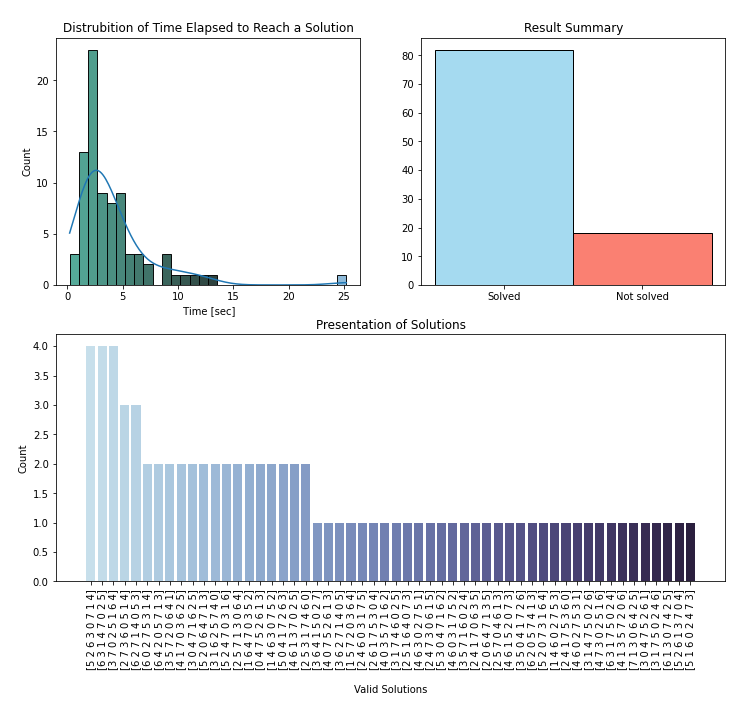

In [89]:
poulation_size, FPS, tournament_selection_k, swap, mutation_rate, crossover_rate = best_parameters_set_8

count_solved = []
time_elapsed_log = []
reached_solution = []
MBF_log = [] 
AES_log = []

for i in range(0,100):
    
    state = EightQueensState(n= 8)
    GenA = Genetic_Algorithm(state, poulation_size = poulation_size,
                             FPS= FPS, tournament_selection_k = tournament_selection_k,
                             swap= swap, mutation_rate = mutation_rate,
                             crossover_rate = crossover_rate, verbose= False)

    solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
    MBF_log.append(-solution.cost())
    if solved:
        time_elapsed_log.append(time_elapsed)
        count_solved.append('Solved')
        reached_solution.append(solution.state)
        AES_log.append(mutation_cycles)
    else: 
        count_solved.append('Not solved')  
        
         

gs = gridspec.GridSpec(2, 2)


fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
cm = sns.color_palette("dark:#5A9_r", 20)
sns.histplot(data = time_elapsed_log, bins= 30, kde=True, ax=ax1)
ax1.set(xlabel=' Time [sec]')
for bin_,i in zip(ax1.patches,cm):
    bin_.set_facecolor(i)
plt.title('\nDistrubition of Time Elapsed to Reach a Solution')


ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
sns.histplot(data= count_solved, color='skyblue', ax=ax2)
ax2.patches[1].set_facecolor('salmon')
ax2.set(ylabel=None)
plt.title('\nResult Summary')


ax3 = fig.add_subplot(gs[1, :]) 
# count number of unique solution and put it in a dictionary 
count_solutions_dic = Counter(str(e) for e in reached_solution)
print(f'{sum(count_solutions_dic.values())} solutions were found for 8 queen puzzle. {len(count_solutions_dic)} of them are unique')

#plot the dictionary
ind = np.arange(len(count_solutions_dic))
palette = sns.color_palette("ch:s=.25,rot=-.25", len(count_solutions_dic))
ax3.bar(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).values(), color=palette)
plt.xticks(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).keys(), rotation = 90)
plt.xlabel('\nValid Solutions')
plt.ylabel('\nCount')
plt.title('\nPresentation of Solutions')

plt.show()

When comapring statistics of both solution, I note that both implementations have successed in finding valid solutions. Although success rates dropped a bit in improved GA (82%) compared to 83% for basic GA, time elapsed to reach a solution has drastically reduced with enahnced GA's time distrubtion mode around 2 sec (5 sec for basic GA).

### Parameters tunning to 12-Queen Puzzle :

In [70]:
poulation_size = [10*12, 20*12]
tournament_selection_k = [2, 4]
mutation_rate_random = np.arange(0.01, 0.07, 0.02)
mutation_rate_swap = np.arange(0.6, 0.8, 0.1)
crossover_rate = np.arange(0.7, 1, 0.1)
comb_list_1 = [poulation_size, [True], [0],[False], mutation_rate_random, crossover_rate]
comb_list_2 = [poulation_size, [True], [0], [True], mutation_rate_swap, crossover_rate]
comb_list_3 = [poulation_size, [False], tournament_selection_k, [False], mutation_rate_random, crossover_rate]
comb_list_4 = [poulation_size, [False], tournament_selection_k, [True], mutation_rate_swap, crossover_rate]

parameters_combinations_1 = [p for p in itertools.product(*comb_list_1)]
parameters_combinations_2 = [p for p in itertools.product(*comb_list_2)]
parameters_combinations_3 = [p for p in itertools.product(*comb_list_3)]
parameters_combinations_4 = [p for p in itertools.product(*comb_list_4)]

parameters_combinations = [*parameters_combinations_1, *parameters_combinations_2,*parameters_combinations_3, *parameters_combinations_4]
print('Number of Parameter Combinations [Poulation_size, FPS, tournament_selection_k, mutation_rate, crossover_rate] are:\n', len(parameters_combinations),'\nTunning ---->\n')
results = {}
# parameter tuning problem 
j = 1
for parameters_set in parameters_combinations:
    print('Combination N.', j, ', Parameters set is:', parameters_set)
    j += 1
    poulation_size, FPS, tournament_selection_k, swap, mutation_rate, crossover_rate = parameters_set
    
    count_solved = []
    time_elapsed_log = []
    reached_solution = []
    MBF_log = [] 
    AES_log = []

    for i in range(0, 10):
        state = EightQueensState(n= 12)
        GenA = Genetic_Algorithm(state,
                     poulation_size = poulation_size, 
                     FPS= FPS, tournament_selection_k = tournament_selection_k,
                     swap = swap, mutation_rate = mutation_rate,
                     crossover_rate = crossover_rate, verbose= False)
        solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
        MBF_log.append(- solution.cost())
        if solved:
            time_elapsed_log.append(time_elapsed)
            AES_log.append(mutation_cycles)
            count_solved.append('Solved')
        else: 
            count_solved.append('Not solved')
    
    # Mean best fitness 
    MBF = round(sum(MBF_log)/len(MBF_log))
    # measure the percentage of runs that reach an optimal solution (goal state)
    success_rate = count_solved.count('Solved')/ len(count_solved)
    try:
        # Average number of evaluations to a solution 
        AES = round(sum(AES_log)/len(AES_log))
        # Average time elaspsed: 
        time_elapsed = round(sum(time_elapsed_log)/len(time_elapsed_log))
    except: 
        #random high number to indicate that optimal solution is not reached. 
        AES, time_elapsed = 100000000, 100000000
    print('--> Result [MBF, AES, Success Rate, Average Time Elapsed to solution]:', [MBF, AES, success_rate, time_elapsed], '\n')
    results[parameters_set] = [MBF, AES, success_rate, time_elapsed]
    
'''normalize values of MBF, AES and success rates to facilitate comparasion between 
results of different parameters combination'''  
results_final = results.copy()

for key,value in results.items():
    MBF_new = (value[0]- min(results.values(), key = lambda kv:kv[0])[0]) /  (max(results.values(), key = lambda kv:kv[0])[0] - min(results.values(), key = lambda kv:kv[0])[0])
    AES_new = (value[1]- min(results.values(), key = lambda kv:kv[1])[1]) / (max((t for t in results.values() if t[1] != 100000000) , key = lambda kv:kv[1])[1] - min(results.values(), key = lambda kv:kv[1])[1])
    success_rate_new = (value[2]- min(results.values(), key = lambda kv:kv[2])[2]) /  (max(results.values(), key = lambda kv:kv[2])[2] - min(results.values(), key = lambda kv:kv[2])[2] + 0.0001)
    time_elapsed_new =  (value[3]- min(results.values(), key = lambda kv:kv[3])[3]) /  (max((t for t in results.values() if t[3] != 100000000) , key = lambda kv:kv[3])[3] - min(results.values(), key = lambda kv:kv[3])[3] + 0.0001)
    #have negative sign for AES and time_elapsed to reflect the need to minimize these factors
    results_final[key] = [MBF_new, -AES_new, success_rate_new, -time_elapsed_new]

# find the sum of all indicators and pick the parameter set with the largest sum
temp = {key: sum(map(lambda ele: ele, results_final[key])) for key in results_final} 
best_parameters_set  = sorted(temp, key = temp.get, reverse = True)[0]
print('\n\nThe BEST TUNED parameter set for 12 queen puzzle is:', best_parameters_set)
print('Poulation_size:',best_parameters_set[0], ', Mutation rate:', best_parameters_set[4], ", Crossover rate:",  best_parameters_set[5])
if best_parameters_set[1]:
    print('Fitness Proportional Selection shall be used for parent selection.')
else: 
    print(f'Tournament selection shall be used for parent selection with a k tournament selection of {best_parameters_set[2]}.')
if best_parameters_set[3]:
    print('Swap mutation shall be used.')
else: 
    print(f'Random resetting mutation shall be used.')
print('Corresponding Mean Best Fitness (MBF):', results[best_parameters_set][0])
print('Corresponding Average number of evaluations to a solution (AES):', results[best_parameters_set][1])
print('Corresponding Success Rate (SR):', results[best_parameters_set][2])
print('Corresponding Average time elapsed to a solution:', results[best_parameters_set][3])

Number of Parameter Combinations [Poulation_size, FPS, tournament_selection_k, mutation_rate, crossover_rate] are:
 144 
Tunning ---->

Combination N. 1 , Parameters set is: (120, True, 0, False, 0.01, 0.7)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 19902, 0.3, 39] 

Combination N. 2 , Parameters set is: (120, True, 0, False, 0.01, 0.7999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 14619, 0.2, 22] 

Combination N. 3 , Parameters set is: (120, True, 0, False, 0.01, 0.8999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 15014, 0.1, 30] 

Combination N. 4 , Parameters set is: (120, True, 0, False, 0.01, 0.9999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 100000000, 0.0, 100000000] 

Combination N. 5 , Parameters set is: (120, True, 0, False, 0.03, 0.7)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [

--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-2, 100000000, 0.0, 100000000] 

Combination N. 46 , Parameters set is: (240, True, 0, True, 0.7999999999999999, 0.7999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-2, 100000000, 0.0, 100000000] 

Combination N. 47 , Parameters set is: (240, True, 0, True, 0.7999999999999999, 0.8999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 100000000, 0.0, 100000000] 

Combination N. 48 , Parameters set is: (240, True, 0, True, 0.7999999999999999, 0.9999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 20874, 0.1, 52] 

Combination N. 49 , Parameters set is: (120, False, 2, False, 0.01, 0.7)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 18180, 0.2, 41] 

Combination N. 50 , Parameters set is: (120, False, 2, False, 0.01, 0.7999999999999999)
--> Result: [MBF, AES, Success 

--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 12176, 0.2, 39] 

Combination N. 90 , Parameters set is: (240, False, 4, False, 0.03, 0.7999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 17463, 0.3, 56] 

Combination N. 91 , Parameters set is: (240, False, 4, False, 0.03, 0.8999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 7865, 0.2, 26] 

Combination N. 92 , Parameters set is: (240, False, 4, False, 0.03, 0.9999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 9090, 0.4, 31] 

Combination N. 93 , Parameters set is: (240, False, 4, False, 0.049999999999999996, 0.7)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 9686, 0.3, 33] 

Combination N. 94 , Parameters set is: (240, False, 4, False, 0.049999999999999996, 0.7999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]:

--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 8586, 0.4, 41] 

Combination N. 135 , Parameters set is: (240, False, 4, True, 0.6, 0.8999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 9430, 0.4, 36] 

Combination N. 136 , Parameters set is: (240, False, 4, True, 0.6, 0.9999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [0, 8836, 0.7, 30] 

Combination N. 137 , Parameters set is: (240, False, 4, True, 0.7, 0.7)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-2, 16348, 0.1, 53] 

Combination N. 138 , Parameters set is: (240, False, 4, True, 0.7, 0.7999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 9280, 0.3, 31] 

Combination N. 139 , Parameters set is: (240, False, 4, True, 0.7, 0.8999999999999999)
--> Result: [MBF, AES, Success Rate, Average Time Elapsed to solution]: [-1, 9539, 0.2, 33] 

Combination N. 1

Using the tuned parameter set, I make a 100 run of 12 queen puzzle on `Genetic_Algorithm` and I get the following results.


57 solutions were found for 12 queen puzzle. 56 of them are unique


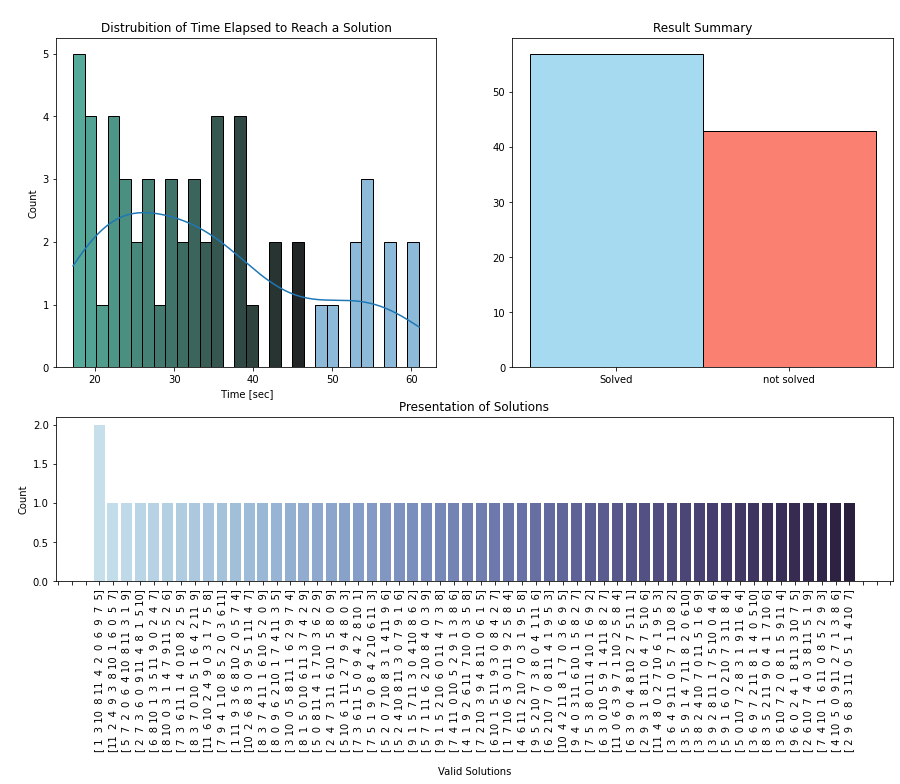

In [95]:
poulation_size, FPS, tournament_selection_k, swap, mutation_rate, crossover_rate = best_parameters_set

count_solved = []
time_elapsed_log = []
reached_solution = []
MBF_log = [] 
AES_log = []

for i in range(0,100):
    
    state = EightQueensState(n= 12)
    GenA = Genetic_Algorithm(state, poulation_size = poulation_size,
                             FPS= FPS, tournament_selection_k = tournament_selection_k,
                             swap= swap, mutation_rate = mutation_rate,
                             crossover_rate = crossover_rate, verbose= False)
    solved, solution, mutation_cycles, n_population_created, time_elapsed, mean_population_fitness_log = GenA.search()
    MBF_log.append(-solution.cost())
    if solved:
        time_elapsed_log.append(time_elapsed)
        count_solved.append('Solved')
        reached_solution.append(solution.state)
        AES_log.append(mutation_cycles)
        print('Run', i, ': Solved')
    else: 
        count_solved.append('not solved') 
        print('Run', i, ': Not solved')


# plot results in three subplot
gs = gridspec.GridSpec(2, 2, height_ratios = [2,1])


fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
cm = sns.color_palette("dark:#5A9_r", 20)
sns.histplot(data = time_elapsed_log, bins= 30, kde=True, ax=ax1)
ax1.set(xlabel=' Time [sec]')
for bin_,i in zip(ax1.patches,cm):
    bin_.set_facecolor(i)
plt.title('\nDistrubition of Time Elapsed to Reach a Solution')


ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
sns.histplot(data= count_solved, color='skyblue', ax=ax2)
ax2.patches[1].set_facecolor('salmon')
ax2.set(ylabel=None)
plt.title('\nResult Summary')


ax3 = fig.add_subplot(gs[1, :]) 
# count number of unique solution and put it in a dictionary 
count_solutions_dic = Counter(str(e) for e in reached_solution)
print(f'\n{sum(count_solutions_dic.values())} solutions were found for {state.n} queen puzzle. {len(count_solutions_dic)} of them are unique')

#plot the dictionary
ind = np.arange(len(count_solutions_dic))
palette = sns.color_palette("ch:s=.25,rot=-.25", len(count_solutions_dic))
ax3.bar(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).values(), color=palette)
plt.xticks(ind, dict(sorted(count_solutions_dic.items(), key=lambda item: item[1], reverse = True)).keys(), rotation = 90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))


plt.xlabel('\nValid Solutions')
plt.ylabel('\nCount')
plt.title('\nPresentation of Solutions')

plt.show()

57% success rate was reported. Solutions took on average less than 40 sec.
### Definicency: 
A known deficiency in my approach is not using parameter control. The set of algorithm parameters is static/ deterministic through the run, although it has been proven that a different value of parameters might be optimal at different stages of the evolutionary process.